# Setting

In [1]:
# Base
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
from time import time
import itertools
import joblib
import os

#NLP
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import string
from textblob import TextBlob


#ML
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Gdrive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# Function that remove the punctuation
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [3]:
# Import Lemmatized dataset 
path = ''
df = pd.read_csv(path)
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

# Classification

In [4]:
classification_df = df[['Score', 'Lemmatized Text']]

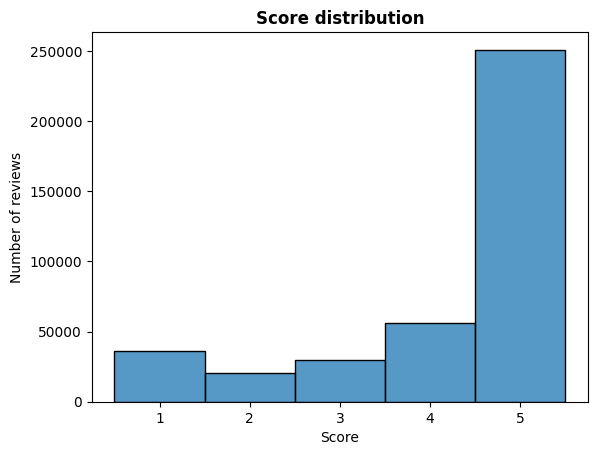

In [35]:
sns.histplot(classification_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")
plt.savefig('Score_distrubtion_multi.png')

In [ ]:
print(classification_df['Score'].value_counts()/len(classification_df['Score']));

In [6]:
# Define a sample size by considering the total number of reviews belonging to the minority class
sample_size = classification_df.groupby('Score').count().min()[0]

In [7]:
df_downsampled = classification_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Score,Lemmatized Text
336961,1,"[slight, carry, flavor, awful, flavor, overpow..."
221567,1,"[otherwise, total, waste, money, lasted, liter..."
243201,1,"[taste, like, hot, sweet, apple, juice, cider,..."
349296,1,"[gumballs, arrived, quick, lot, inside, unfort..."
67237,1,"[second, order, product, first, order, outstan..."
...,...,...
97386,5,"[love, mustard, ive, regular, mustard, frustra..."
235026,5,"[settle, tea, good, good, asthma, diabetes, ar..."
365695,5,"[arrived, time, packed, well, broken, filled, ..."
203689,5,"[good, product, great, price, waited, lowest, ..."


In [ ]:
df_downsampled.shape

Text(0, 0.5, 'Number of reviews')

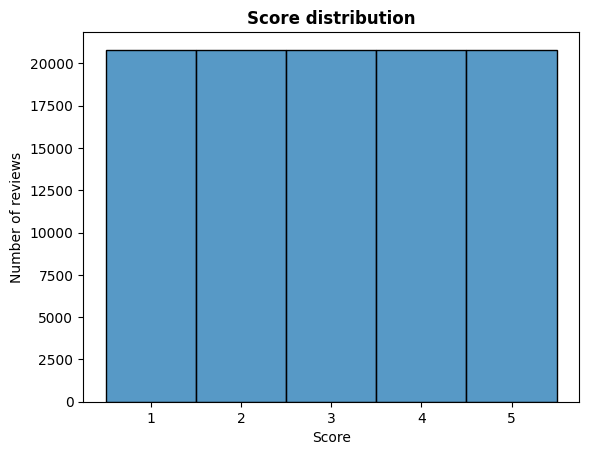

In [10]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [37]:
df_downsampled.shape

(104010, 2)

In [8]:
# Split training test set 
X_train, X_test, y_train, y_test = train_test_split(df_downsampled['Lemmatized Text'], 
                                                    df_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=df_downsampled['Score'])

# **Multi-label classification**

## **1 - Bag-of-Word**

In [13]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(X_train.astype(str)) 
X_train_BOW = cv_model.transform(X_train.astype(str))

In [ ]:
# Run SVD with 3000 components

# n_components = 3000
# tSVD_BOW = TruncatedSVD(n_components = n_components)
# SVD_BOW = tSVD_BOW.fit(X_train_BOW)

# Cumulative variance
# cum_var = np.cumsum(SVD_BOW.explained_variance_ratio_)

# Save fit in local 

# joblib.dump(SVD_BOW, "SVD_BOW_3000.joblib")

In [24]:
# Load SVD
path = ''
SVD_BOW_3000 = joblib.load(path)
cum_var = np.cumsum(SVD_BOW_3000.explained_variance_ratio_)

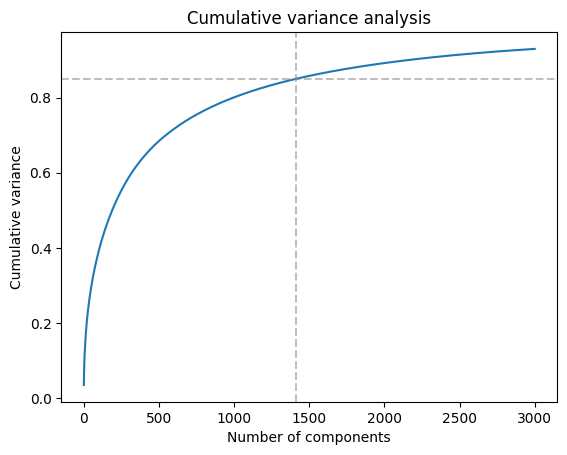

In [30]:
# Plot cumulative variance
fig, ax = plt.subplots()
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.title('Cumulative variance analysis')
ax.axvline(x=1413, color='gray', linestyle='dashed', alpha=0.5)
ax.axhline(y=0.85, color='gray', linestyle='dashed', alpha=0.5)
plt.savefig('SVD_BOW.png')
plt.show()


In [ ]:
threshold = 0.85 # Proportion of variance that we want to explain
n_components = np.argmax(cum_var >= threshold) + 1
print("Number of components needed to explain an 85% variance are: ", n_components)

In [22]:
# # SVD with optimal components

# tSVD_BOW = TruncatedSVD(n_components = 1413)
# SVD_BOW = tSVD_BOW.fit(X_train_BOW)

In [23]:
# # Apply the trasfrom on training and test set

# X_train_BOW = tSVD_BOW.transform(X_train_BOW)

# X_test_BOW = cv_model.transform(X_test.astype(str))
# X_test_BOW = tSVD_BOW.transform(X_test_BOW)

In [26]:
# # Save final dataset 

# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW.npy', X_train_BOW)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW.npy', X_test_BOW)

In [35]:
# Load dataset
path = ''
X_train_BOW = np.load(path + 'X_train_BOW.npy')
X_test_BOW = np.load(path + 'X_test_BOW.npy')

### Algorithm Implementation

#### Logistic Regression

In [ ]:
# model = LogisticRegression(random_state=1)

# # Fine tuning

# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# Define the grid search

# grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
# start = time()

# Cross validation and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)

# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Save the results of the tuning 

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [36]:
# Load fitted model
path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_lr_BOW = loaded_grid_search.best_estimator_

Best result: 0.485791 using {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}


#### Random Forest

In [ ]:
# model = RandomForestClassifier()

# Fine tuning
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']

# Define the grid reasearch
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# Start the clock, train the classifier, then stop the clock
# start = time()

# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy', error_score=0)
# grid_result = grid_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# SSave the results of the tuning 
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [37]:

# Load fitted model
path = ''
loaded_grid_search = joblib.load(path)

# Results Summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_rf_BOW = loaded_grid_search.best_estimator_

Best result: 0.375527 using {'max_features': 'sqrt', 'n_estimators': 1000}


#### K-NN

In [ ]:
# model = KNeighborsClassifier(weights='distance')

# # Fine tuning
# n_neighbors = range(1, 21, 4)

# # Define the grid reasearch
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))
# # Summary dei risultati

# # Save the results of the tuning 
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [38]:
# Load fitted model
path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_knn_BOW = loaded_grid_search.best_estimator_

Best result: 0.319585 using {'n_neighbors': 17}


#### XG-Boost

In [ ]:
# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)
# model = XGBClassifier( tree_method = 'gpu_hist', predictor = 'gpu_predictor')

# # Fine tuning 
# max_depth = [1,2,3, 4, 5, 6, 7, 8, 9]
# eta  = [0.001, 0.01, 0.01, 0.2, 0.4, 0.6, 0.8]
# colsample_bytree = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
# sampling_method = ['uniform', 'gradient_based']

# # Define the grid reasearch
# grid = dict(max_depth=max_depth, eta =eta, colsample_bytree = colsample_bytree, sampling_method = sampling_method)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter= 6, cv=2, scoring='accuracy', error_score=0, n_jobs=-1, random_state=0, verbose=4)
# grid_result = random_search.fit(X_train_BOW, y_train_xg)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)


In [39]:
# Load fitted model
path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_xgboost_BOW = loaded_grid_search.best_estimator_

Best result: 0.413065 using {'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.5}


### Analysis of results

In [ ]:
models = [model_lr_BOW, model_rf_BOW, model_knn_BOW, model_xgboost_BOW]

# Make a prediction on the test set
results = []
for model in models:
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'RF model', 'KNN model', 'XGBOOST model']
print(df_results)

In [67]:
# Save results dataframe
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW.csv')

In [41]:
# Load results dataframe
# path = ''
# results_BOW = pd.read_csv(path)
# print(results_BOW)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.221197   0.220327  0.221194  0.218626
1       RF model  0.283915   0.279124  0.283912  0.278989
2      KNN model  0.225139   0.230686  0.225138  0.222418
3  XGBOOST model  0.269557   0.270507  0.269555  0.269756


In [ ]:
models = [model_lr_BOW, model_rf_BOW, model_knn_BOW, model_xgboost_BOW]
model_names = ["Logistic Regression", "Random Forest", "K-NN", "XG-boost"]
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper')


# Confusion matrix for each model
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test_xg)
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_BOW))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks( np.arange(5),classes)
        plt.yticks( np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_BOW))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()


## **2 - TF-IDF**

In [8]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True) 
tv_model = tv.fit(X_train.astype(str)) 
X_train_TFIDF = tv.transform(X_train.astype(str)) # Vettorizzo

In [ ]:
# Run SVD with 5000 components

# n_components = 5000
# tSVD_TFIDF = TruncatedSVD(n_components = n_components)
# SVD_TFIDF_5000 = tSVD_TFIDF.fit(X_train_TFIDF)

# Cumulative variance
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

# Save SVD on the disk
# joblib.dump(SVD_TFIDF_5000, "SVD_TFIDF_5000.joblib")


In [33]:
# Load SVD
path = ''
SVD_TFIDF_5000 = joblib.load(path)
cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

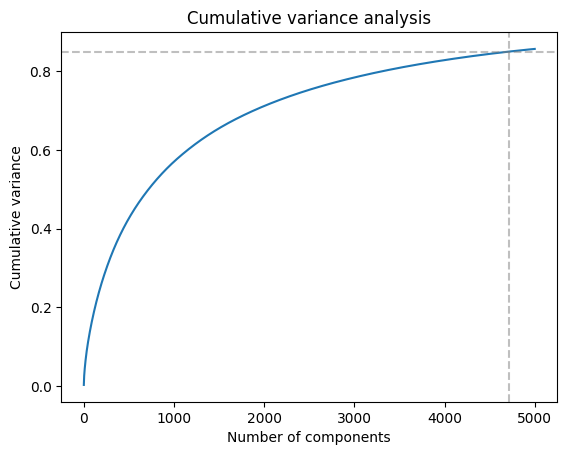

In [35]:
# Cumulative variance plot
fig, ax = plt.subplots()
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.title('Cumulative variance analysis')
ax.axvline(x=4719, color='gray', linestyle='dashed', alpha=0.5)
ax.axhline(y=0.85, color='gray', linestyle='dashed', alpha=0.5)
plt.savefig('SVD_TFIDF.png')
plt.show()

In [ ]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Number of components needed to explain an 85% variance are : ", n_components)

In [64]:
# # Fit optimal SVD
# tSVD_TFIDF = TruncatedSVD(n_components = 4719)
# SVD_TFIDF = tSVD_TFIDF.fit(X_train_TFIDF)

In [65]:
# # Aplly the trasformation on the training and test set
# X_train_TFIDF = tSVD_TFIDF.transform(X_train_TFIDF)

# X_test_TFIDF = tv_model.transform(X_test.astype(str))
# X_test_TFIDF = SVD_TFIDF.transform(X_test_TFIDF)

In [67]:
# Save final datasets

# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_train_TFIDF.npy', X_train_TFIDF)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_test_TFIDF.npy', X_test_TFIDF)

In [42]:
# Load datasets
path = ''
X_train_TFIDF = np.load(path + 'X_train_TFIDF.npy')
X_test_TFIDF = np.load(path + 'X_test_TFIDF.npy')

### Algorithm Implementation

#### Logistic regression

In [ ]:
# model = LogisticRegression(random_state=1)

# # Fine tuning
# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# # Define the grid reasearch
# grid = dict(penalty=penalty,C=c_values)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# # CV and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning
# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF.joblib'
# # joblib.dump(grid_result, path)

In [43]:
# Load fitted models

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_lr_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.443364 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}


#### K-NN

In [ ]:
# model = KNeighborsClassifier(weights='distance')

# # Fine tuning
# n_neighbors = range(1, 21, 1)

# # Define the grid reasearch
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 

# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF.joblib'
# # loaded_grid_search = joblib.load(path)

In [44]:
# Load fitted model

path = ''
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.237697 using {'n_neighbors': 20}


#### Random Forest

In [ ]:
# model = RandomForestClassifier()

# # Fine tuning
# max_depth = [1, 2, 3, 4, 5, 6, 7]
# n_estimators = [10, 100, 200, 400, 600, 800, 1000]
# max_features = ['sqrt', 'log2']

# #Define the grid reasearch
# grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth = max_depth)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, path)

In [45]:

# Load fitted models
path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_rf_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.371407 using {'n_estimators': 1000, 'max_features': 'sqrt'}


#### XGBoost

In [ ]:
# # Holdout procedure

# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='multi:softmax')
# model_xgboost_TFIDF = model.fit(X_train_TFIDF, y_train_xg)

# # Save fitted model
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/xgboost_holdout_TFIDF.joblib'
# joblib.dump(model_xgboost_TFIDF, path)

In [20]:
# Load fitted model
path = ''
model_xgboost_TFIDF = joblib.load(path)

### Analysis of the results

In [ ]:
models = [model_lr_TFIDF, model_knn_TFIDF, model_rf_TFIDF, model_xgboost_TFIDF]

# Predictions on the test set
results = []
for model in models:
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', "Random Forest" XGBOOST model']
print(df_results)

In [38]:
# Dataframe with the results for each models

df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', "Random Forest" , 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.313976   0.305260  0.313967  0.293167
KNN model      0.220299   0.214467  0.220295  0.172065
Random Forest  0.291703   0.286056  0.291697  0.286066
XGBOOST model  0.429254   0.420693  0.429246  0.423616


In [44]:
# #  Save the results
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_TFIDF.csv')

In [47]:
# # Load the results Dataframe
# results_TFIDF = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Results/df_results_TFIDF.csv')
# print(results_TFIDF)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.313976   0.305260  0.313967  0.293167
1      KNN model  0.220299   0.214467  0.220295  0.172065
2  Random Forest  0.291703   0.286056  0.291697  0.286066
3  XGBOOST model  0.429254   0.420693  0.429246  0.423616


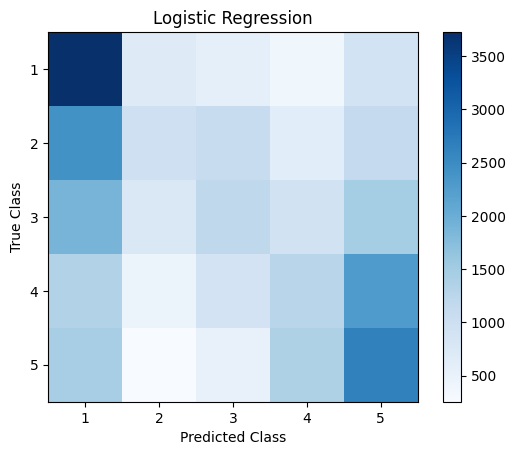

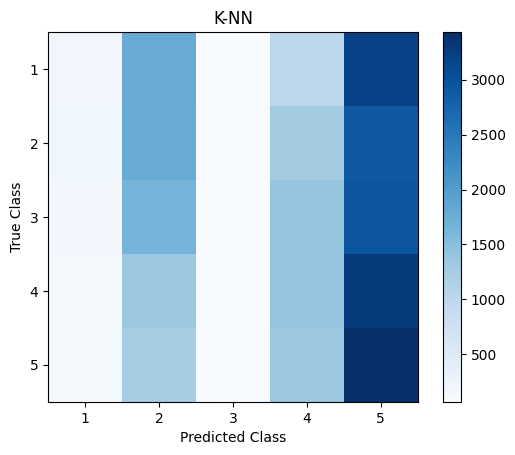

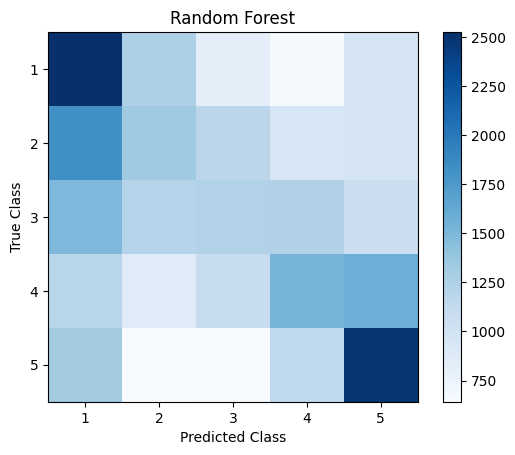

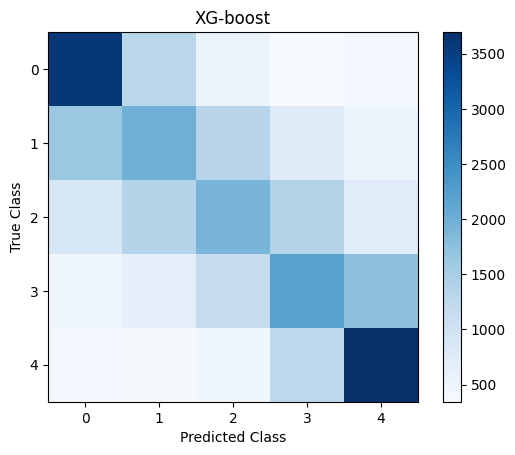

<Figure size 640x480 with 0 Axes>

In [73]:
models = [model_lr_TFIDF, model_knn_TFIDF, model_rf_TFIDF, model_xgboost_TFIDF]
model_names = ["Logistic Regression", "K-NN", "Random Forest", "XG-boost"]
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Multiclasse')
#Confusion matrix for each model
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        conf_matrix = confusion_matrix(y_test_xg, model.predict(X_test_TFIDF))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(5)
        plt.xticks(tick_marks, np.arange(5))
        plt.yticks(tick_marks, np.arange(5))
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_TFIDF))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix_TFIDF.png')
        plt.show()
        plt.clf()

## **3 - Word2Vec**

https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

In [18]:
# Fit the w2v model on the training dataset
w2v_model = gensim.models.Word2Vec(X_train, vector_size=300, window=8, min_count=2)

To generate a vector representative of each review we will create a vector consisting of the average (component by component) of the vectors of the words belonging to the review.

In [ ]:
words = set(w2v_model.wv.index_to_key) # Lista di parole presenti nel modello W2V

# X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
#                          for ls in X_train])
# X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
#                          for ls in X_test])

In [27]:
# Load X_train_vect and X_test_vect
path = ''
X_train_vect = np.load(path + "X_train_vect.npy", allow_pickle=True)
X_test_vect = np.load(path + "X_test_vect.npy", allow_pickle=True)

### Example

To better explain the above, let us use this example:

In [ ]:
# The first review of the training is as follows
X_train.head(1)

In [ ]:
# The first two words are 'love' and 'walker'. I print the vectors of these two words
w2v_model.wv.get_vector('love')

In [ ]:
w2v_model.wv.get_vector('walker')

To see that they are identical, we print the first two elements of the first list in X_train_vec. These two elements correspond to the vectors of the first two words of the selected review, i.e. 'love' and 'walker'.

In [ ]:
X_train_vect[0][0]

In [ ]:
X_train_vect[0][1]

### Final dataset

We are going to loop over these lists. Each sentence will have a different number of words and consequently a different number of arrays to be averaged

In [28]:
# Final datasets

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

### Algorithm Implementation

##### Logistic Regression

In [ ]:
# model = LogisticRegression(random_state=1)

# # Fine tuning
# solvers = ['lbfgs', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10]

# # Define the grid reasearch
# grid = dict(penalty=penalty,C=c_values, solver = solvers)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_vect_avg, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_W2V.joblib'
# joblib.dump(grid_result, path)

In [29]:
# Load fitted models

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_lr_W2V = loaded_grid_search.best_estimator_

Best result: 0.472592 using {'solver': 'saga', 'penalty': 'l2', 'C': 200}


#### Random Forest

In [54]:
# model = RandomForestClassifier()

# # Fine Tuning
# n_estimators = [10, 50, 70, 100, 200, 300, 400, 500]
# max_features = ['sqrt', 'log2']

# # Define the grid reasearch 
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# # # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_vect_avg, y_train) 
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 
# joblib.dump(grid_result, 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/rf_gridsearch_W2V.joblib')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=500;, score=0.432 total time= 8.2min
[CV 2/2] END max_features=sqrt, n_estimators=500;, score=0.435 total time= 8.0min
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=0.422 total time= 1.6min
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=0.419 total time= 1.8min
[CV 1/2] END max_features=log2, n_estimators=200;, score=0.428 total time= 2.0min
[CV 2/2] END max_features=log2, n_estimators=200;, score=0.428 total time= 2.1min
[CV 1/2] END max_features=log2, n_estimators=70;, score=0.414 total time=  45.3s
[CV 2/2] END max_features=log2, n_estimators=70;, score=0.412 total time=  33.2s
[CV 1/2] END max_features=log2, n_estimators=10;, score=0.346 total time=   4.7s
[CV 2/2] END max_features=log2, n_estimators=10;, score=0.348 total time=   4.6s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=0.429 total time= 3.7min
[CV 2/2] END max_features=sqrt, n_estimato

In [30]:

# # Load fitted model
loaded_grid_search = joblib.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/rf_gridsearch_W2V.joblib')

# # Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# # Save the model with the best performance
model_rf_W2V = loaded_grid_search.best_estimator_

Best result: 0.433420 using {'n_estimators': 500, 'max_features': 'sqrt'}


#### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')
# # Fine tuning
# n_neighbors = range(1, 21, 1)

# # Define the grid reasearch
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_vect_avg, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_W2V.joblib'
# joblib.dump(grid_result, path)

In [31]:
# Load fitted model

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_knn_W2V = loaded_grid_search.best_estimator_

Best result: 0.374360 using {'n_neighbors': 20}


#### XGBoost

In [ ]:
# # Holdout procedure
# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='multi:softmax')
# model_xgboost_W2V = model.fit(X_train_vect_avg, y_train_xg)

# # Save fitted model
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_holdout_W2V.joblib'
# joblib.dump(model_xgboost_W2V, path)

In [32]:
# Load fitted model
path = ''
model_xgboost_W2V = joblib.load(path)

### Analysis of the results

In [59]:
models = [model_lr_W2V, model_knn_W2V, model_rf_W2V, model_xgboost_W2V]

# Predictions on the test set
results = []
for model in models:
    if model == models[3]:
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_vect_avg)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_vect_avg)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Dataframe with the results for each mode
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest model', 'XGBOOST model']
print(df_results)

[3 2 1 ... 4 3 2]
                     Accuracy  Precision    Recall  F1 Score
LR model             0.472935   0.464525  0.472927  0.467340
KNN model            0.385476   0.396524  0.385471  0.389232
Random Forest model  0.447585   0.435090  0.447577  0.438207
XGBOOST model        0.453097   0.444104  0.453089  0.447424


In [60]:
# # Save results dataframe
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V.csv')

In [76]:
# # Load
# results_W2V = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V.csv')
# print(results_W2V)

            Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0             LR model  0.472935   0.464525  0.472927  0.467340
1            KNN model  0.385476   0.396524  0.385471  0.389232
2  Random Forest model  0.447585   0.435090  0.447577  0.438207
3        XGBOOST model  0.453097   0.444104  0.453089  0.447424


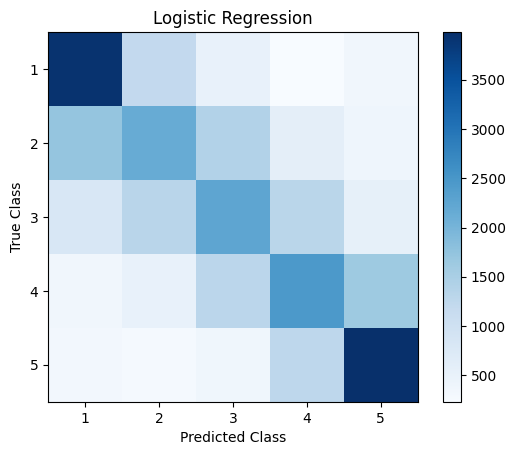

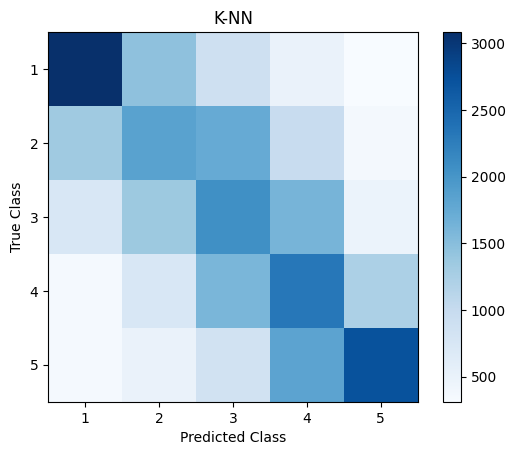

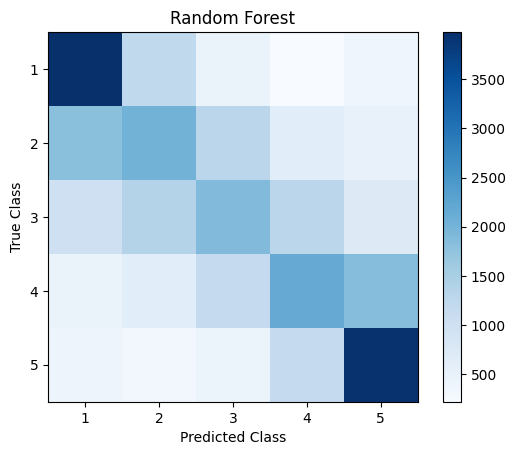

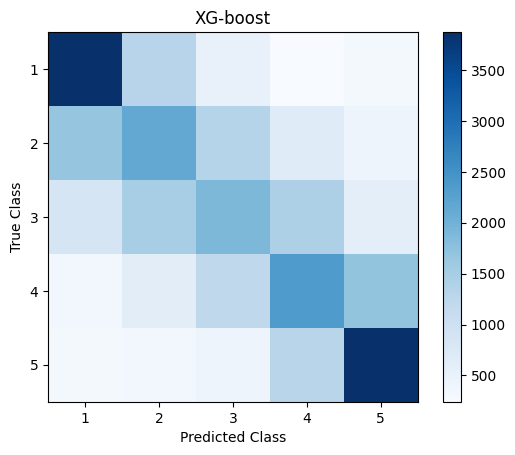

<Figure size 640x480 with 0 Axes>

In [79]:
models = [model_lr_W2V, model_knn_W2V, model_rf_W2V, model_xgboost_W2V]
model_names = ["Logistic Regression", "K-NN", "Random Forest", "XG-boost"]

# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper')
# Confusion matrix for each model
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        conf_matrix = confusion_matrix(y_test_xg, model.predict(X_test_vect_avg))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5),  classes)
        plt.yticks(np.arange(5),  classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix_W2V.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_vect_avg))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        # plt.savefig(model_names[i] + '_confusion_matrix_W2V.png')
        plt.show()
        plt.clf()

# Binary Classification 

In [9]:
# Keep scores other than 3
df_binary = classification_df[classification_df['Score']!=3]

In [10]:
# Binary variable
df_binary.loc[df_binary.Score < 3, "Score"] = 0
df_binary.loc[df_binary.Score > 3, "Score"] = 1
df_binary.head()

,Score,Lemmatized Text
0,1,"[bought, several, vitality, canned, dog, food,..."
1,0,"[product, arrived, labelled, lumbo, halted, pe..."
2,1,"[connection, around, century, light, pillow, c..."
3,0,"[looking, secret, ingredient, robitussin, beli..."
4,1,"[great, staff, great, price, wide, assortment,..."


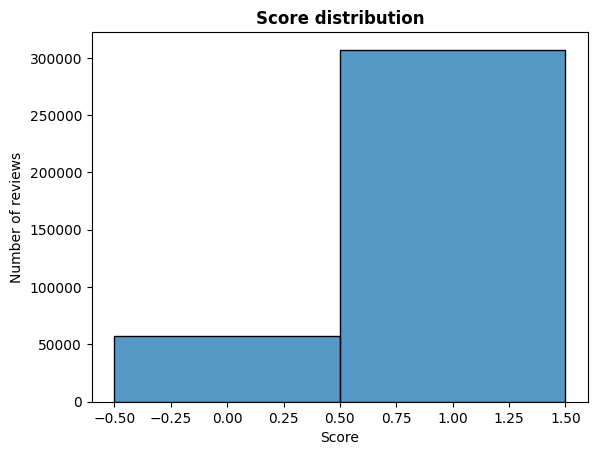

In [36]:
sns.histplot(df_binary['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")
plt.savefig('Score_distrubtion_binary.png')

In [11]:
sample_size_binary = df_binary.groupby('Score').count().min()[0]
sample_size_binary

57108

In [12]:
binary_downsampled = df_binary.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size_binary))
binary_downsampled

,Score,Lemmatized Text
283741,0,"[like, cheer, like, honey, nut, besti, believe..."
110569,0,"[three, boring, cup, coffee, ive, ever, first,..."
302801,0,"[tried, dog, last, resort, measure, worthless,..."
67654,0,"[tried, food, day, first, day, elderly, cat, b..."
305289,0,"[love, sweetened, condensed, milk, use, coffee..."
...,...,...
157472,1,"[bought, cake, mile, bought, sordid, ware, bun..."
266989,1,"[tassimo, coffee, rich, full, favored, quite, ..."
92222,1,"[st, attempt, get, artificial, sweetness, like..."
155750,1,"[wonderful, able, find, dark, roast, coffee, a..."


In [13]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_downsampled["Lemmatized Text"], 
                                                    binary_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=binary_downsampled['Score'])

## **1 - Bag-of-Word**

In [13]:
cv_bin = CountVectorizer(min_df=0., max_df=1.0)
cv_model_bin = cv_bin.fit(X_train_bin.astype(str)) 
X_train_BOW_bin = cv_model_bin.transform(X_train_bin.astype(str))

In [31]:
X_train_BOW_bin.shape

(79951, 80905)

In [ ]:
# # Run SVD
# n_components = 3000
# tSVD_BOW_bin = TruncatedSVD(n_components = n_components)
# SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)

# # Cumulative varianza
# cum_var = np.cumsum(SVD_BOW_bin.explained_variance_ratio_)

# # Save SVD in local
# joblib.dump(SVD_BOW_bin, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_3000_bin.joblib")

In [15]:
# Load SVD
path =''
SVD_BOW_3000_bin = joblib.load(path)
cum_var = np.cumsum(SVD_BOW_3000_bin.explained_variance_ratio_)

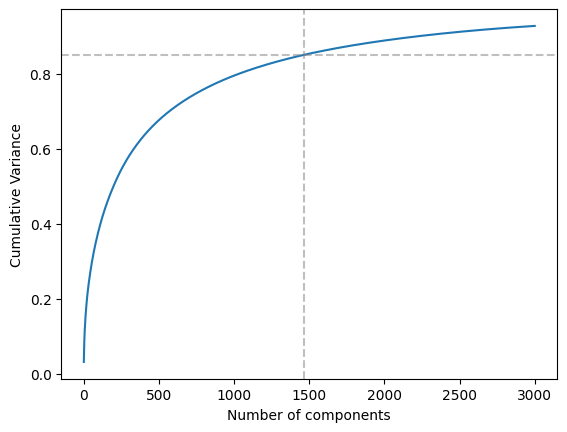

In [19]:
# Plot cumulative variance
fig, ax = fig, ax = plt.subplots()
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative Variance")
ax.axvline(x= 1466, color='gray', linestyle='dashed', alpha=0.5)
ax.axhline(y=0.85, color='gray', linestyle='dashed', alpha=0.5)
#plt.savefig('SVD_BOW_bin.png')
plt.show()

In [ ]:
threshold = 0.85 # Proportion of variance that we want to explain
n_components = np.argmax(cum_var >= threshold) + 1
print("Number of components needed to explain an 85% variance are : ", n_components)

In [14]:
# # SVD with optimal components
# tSVD_BOW_bin = TruncatedSVD(n_components = 1466)
# SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)

# # Save optimal SVD
# joblib.dump(SVD_BOW_bin, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_bin_optim.joblib")

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_bin_optim.joblib']

In [15]:
# # Apply the trasformation on training and test set
# X_train_BOW_bin = tSVD_BOW_bin.transform(X_train_BOW_bin)

# X_test_BOW_bin = cv_model_bin.transform(X_test_bin.astype(str))
# X_test_BOW_bin = SVD_BOW_bin.transform(X_test_BOW_bin)

In [16]:
# # Save final datasets
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW_bin.npy', X_train_BOW_bin)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW_bin.npy', X_test_BOW_bin)

In [14]:
# Load final datasets
path = ''
X_train_BOW_bin = np.load(path + 'X_train_BOW_bin.npy')
X_test_BOW_bin = np.load(path + 'X_test_BOW_bin.npy')

### Algorithm Implementation

##### Logistic Regression

In [44]:
# model = LogisticRegression(random_state=1)

# # Grid reasearch
# solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [900, 700, 500, 200, 100, 50, 10]
# grid = dict(solver=solvers,penalty=penalty,C=c_values)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
# # end = time()

# # Save fine tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/logreg_gridsearch_BOW_bin.joblib'
# joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ....C=100, penalty=l2, solver=saga;, score=0.866 total time=  53.5s
[CV 2/2] END ....C=100, penalty=l2, solver=saga;, score=0.865 total time=  47.1s
[CV 1/2] END ......C=10, penalty=l2, solver=sag;, score=0.865 total time=  47.7s
[CV 2/2] END ......C=10, penalty=l2, solver=sag;, score=0.864 total time=  48.2s
[CV 1/2] END ....C=50, penalty=None, solver=sag;, score=0.000 total time=   0.1s
[CV 2/2] END ....C=50, penalty=None, solver=sag;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=900, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=900, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=100, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=100, penalty=None, solver=saga;,

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW_bin.joblib']

In [15]:
# Load fine tuning
path = ''
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_lr_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.865443 using {'solver': 'saga', 'penalty': 'l2', 'C': 100}


##### Random Forest

In [55]:
# model = RandomForestClassifier()

# # Grid reasearch
# max_depth = [1, 2, 3, 4, 5, 6, 7]
# n_estimators = [10, 100, 200, 300, 500, 700, 1000]
# max_features = ['sqrt', 'log2']
# grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth = max_depth)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
# end = time()

# # Save fine tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/rf_gridsearch_BOW_bin.joblib'
# joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=4, max_features=sqrt, n_estimators=200;, score=0.734 total time= 3.1min
[CV 2/2] END max_depth=4, max_features=sqrt, n_estimators=200;, score=0.726 total time= 2.6min
[CV 1/2] END max_depth=4, max_features=log2, n_estimators=200;, score=0.677 total time=  35.3s
[CV 2/2] END max_depth=4, max_features=log2, n_estimators=200;, score=0.658 total time=  35.6s
[CV 1/2] END max_depth=6, max_features=log2, n_estimators=1000;, score=0.693 total time= 4.6min
[CV 2/2] END max_depth=6, max_features=log2, n_estimators=1000;, score=0.682 total time= 5.0min
[CV 1/2] END max_depth=7, max_features=sqrt, n_estimators=300;, score=0.744 total time= 5.9min
[CV 2/2] END max_depth=7, max_features=sqrt, n_estimators=300;, score=0.741 total time= 6.9min
[CV 1/2] END max_depth=3, max_features=log2, n_estimators=10;, score=0.635 total time=   2.9s
[CV 2/2] END max_depth=3, max_features=log2, n_estimators=10;, score=0.591 total tim

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/rf_gridsearch_BOW_bin.joblib']

In [16]:
# Load fine tuning
path = ''
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_rf_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.742442 using {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 7}


#### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')

# # Grid reasearch
# n_neighbors = range(1, 21, 1)
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))


# # Save fine tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimeted/Classificazione_binaria/BOW/knn_gridsearch_BOW_bin.joblib'
# joblib.dump(grid_result, path)

In [17]:
# Load fine tuning
path = ''
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_knn_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.702142 using {'n_neighbors': 20}


#### XGBoost

In [14]:
# Holdout procedure

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective= 'binary:logistic')
# xgboost_model = model.fit(X_train_BOW_bin, y_train_bin)

# # Save fitted model
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/xgboost_holdout_BOW_bin.joblib'
# joblib.dump(xgboost_model, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/xgboost_holdout_BOW_bin.joblib']

In [18]:
# Load model
path = ''
model_xgboost_BOW_bin = joblib.load(path)

### Analysis of the results

In [20]:
models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, model_xgboost_BOW_bin]

# Predictions on the test set
results = []
for model in models:
    y_pred_bin = model.predict(X_test_BOW_bin)
    acc = accuracy_score(y_test_bin, y_pred_bin)
    prec = precision_score(y_test_bin, y_pred_bin, average='macro')
    recall = recall_score(y_test_bin, y_pred_bin, average='macro')
    f1 = f1_score(y_test_bin, y_pred_bin, average='macro')
    results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest', 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.870626   0.870652  0.870626  0.870624
KNN model      0.548344   0.557556  0.548338  0.529502
Random Forest  0.746067   0.748374  0.746069  0.745477
XGBOOST model  0.810390   0.810553  0.810390  0.810365


In [21]:
# # Save results dataframe
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW_bin.csv')

In [22]:
# # Load results dataframe
# results_BOW_bin = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW_bin.csv')
# print(results_BOW_bin)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.870626   0.870652  0.870626  0.870624
1      KNN model  0.548344   0.557556  0.548338  0.529502
2  Random Forest  0.746067   0.748374  0.746069  0.745477
3  XGBOOST model  0.810390   0.810553  0.810390  0.810365


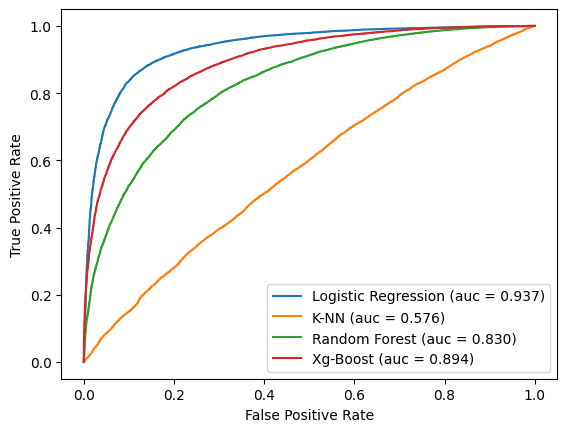

In [21]:
# Roc Curves
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/BOW/')

models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, model_xgboost_BOW_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

plt.figure()
for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_BOW_bin)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
# plt.savefig("ROC_curve_BOW_all.png")
plt.show()

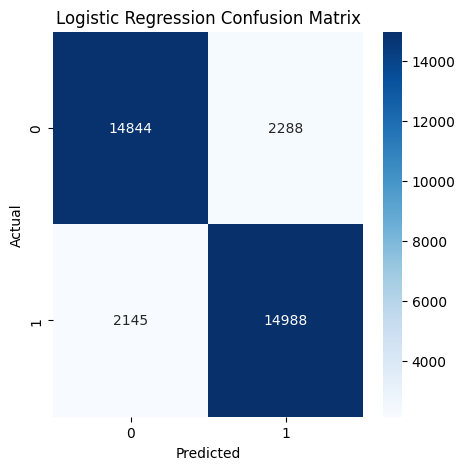

<Figure size 640x480 with 0 Axes>

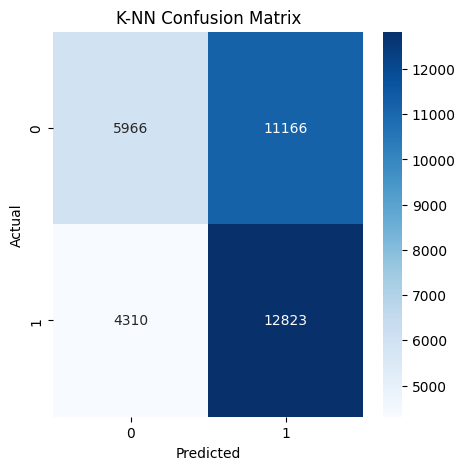

<Figure size 640x480 with 0 Axes>

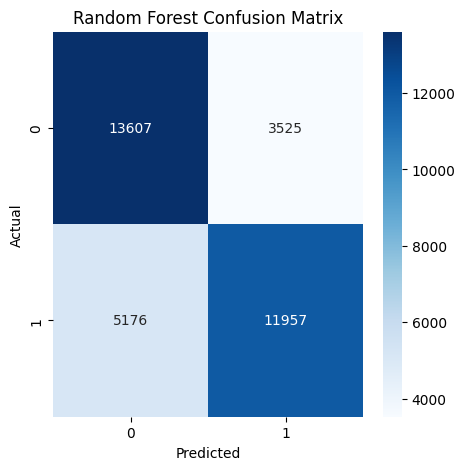

<Figure size 640x480 with 0 Axes>

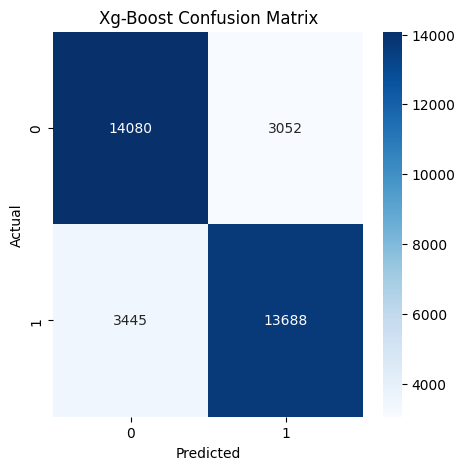

<Figure size 640x480 with 0 Axes>

In [26]:
# Confusion matrices
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/BOW')

models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, model_xgboost_BOW_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

# Create confusion matrices and save the plots
for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_BOW_bin)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    # plt.savefig(name+"_confusion_matrix_BOW.png")
    plt.show()
    plt.clf()

## **2 - TF-IDF**

In [ ]:
tv_bin = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_bin = tv_bin.fit(X_train_bin.astype(str))
X_train_TFIDF_bin = tv_bin.transform(X_train_bin.astype(str))

In [ ]:
# # Run SVvd
# n_components = 5000
# tSVD_TFIDF_bin = TruncatedSVD(n_components = n_components)
# SVD_TFIDF_5000_bin = tSVD_TFIDF_bin.fit(X_train_TFIDF)

# # Cumulative variance
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

# # Save SVD in local
# # joblib.dump(SVD_TFIDF_5000, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_TFIDF_5000_bin.joblib")

In [20]:
# Load SVD
path = ''
SVD_TFIDF_5000_bin = joblib.load(path)
cum_var = np.cumsum(SVD_TFIDF_5000_bin.explained_variance_ratio_)

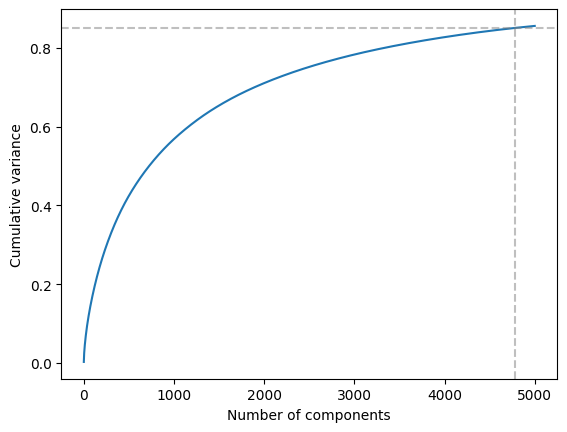

In [21]:
# Plot cumulative variance
fig, ax = fig, ax = plt.subplots()
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
ax.axvline(x= 4776, color='gray', linestyle='dashed', alpha=0.5)
ax.axhline(y=0.85, color='gray', linestyle='dashed', alpha=0.5)
plt.savefig('SVD_tfidf_bin.png')
plt.show()

In [ ]:
threshold = 0.85 # Proportion of variance that we want to expla
n_components = np.argmax(cum_var >= threshold) + 1
print("Number of components needed to explain an 85% variance are : ", n_components)

In [ ]:
# # Fit optimal SVD
# tSVD_TFID_bin = TruncatedSVD(n_components = 4776) 
# SVD_TFIDF_bin = tSVD_TFIDF.fit(X_train_TFIDF)

In [ ]:
# # Apply the trasformation on the training and test set
# X_train_TFIDF_bin = tSVD_TFID_bin.transform(X_train_bin.astype(str))

# X_test_TFIDF_bin = tv_model_bin.transform(X_test_bin.astype(str))
# X_test_TFIDF_bin = SVD_TFIDF_bin.transform(X_test_TFIDF_bin)

In [ ]:
# # Save final datasets
# np.save('/content/gdrive/MyDrive/TextMiningProject/Dataset_TFIDF/X_train_TFIDF_bin.npy', X_train_TFIDF_bin)
# np.save('/content/gdrive/MyDrive/TextMiningProject/Dataset_TFIDF/X_test_TFIDF_bin.npy', X_test_TFIDF_bin)

In [22]:
# Load final datasets
path = ''
X_train_TFIDF_bin = np.load(path + 'X_train_TFIDF_bin.npy', allow_pickle=True)
X_test_TFIDF_bin = np.load(path + 'X_test_TFIDF_bin.npy', allow_pickle=True)

### Algorithm Implementation

#### Logistic Regression

In [ ]:
# model = LogisticRegression(random_state=1)

# # Fine tuning 
# solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0]

# # Define the grid reasearch
# grid = dict(penalty=penalty,C=c_values)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 
# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF_bin.joblib'
# # joblib.dump(grid_result, path)


In [23]:
# Load fitted models

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance

model_lr_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.873097 using {'penalty': 'l2', 'C': 1.0}


#### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')

# # Fine tuning
# n_neighbors = range(1, 21, 1)

# # Define the grid reasearch
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning

# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF_bin.joblib'
# # loaded_grid_search = joblib.load(path)

In [24]:
# Load fitted model

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_knn_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.624833 using {'n_neighbors': 10}


#### Random Forest

In [ ]:
# model = RandomForestClassifier()

# # Fine tuning
# max_depth = [1, 2, 3, 4, 5, 6, 7]
# n_estimators = [10, 100, 200, 400, 600, 800, 1000]
# max_features = ['sqrt', 'log2']
# # Define the grid reasearch 
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning
# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_TFIDF_bin.joblib'
# # joblib.dump(grid_result, path)

# model_path = '/content/gdrive/MyDrive/TextMiningProject/rf_gridsearch_TFIDF_bin.joblib'
# joblib.dump(grid_result, model_path)

In [25]:

# Load fitted models
path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_rf_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.776038 using {'n_estimators': 800, 'max_features': 'sqrt'}


#### XGBoost

In [35]:
# # Holdout 
# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='binary:logistic')
# model_xgboost = model.fit(X_train_TFIDF_bin, y_train_bin)

# # Save hold out
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/model_xgboost_TFIDF_bin.json'
# joblib.dump(model_xgboost, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/model_xgboost_TFIDF_bin.json']

In [26]:
# Load fitted model
path = ''
model_xgboost_TFIDF_bin = joblib.load(path)

### Analyis of the results

In [37]:
models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]

# Make a prediction on the test set
results = []
for model in models:
    y_pred = model.predict(X_test_TFIDF_bin)
    acc = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred, average='macro')
    recall = recall_score(y_test_bin, y_pred, average='macro')
    f1 = f1_score(y_test_bin, y_pred, average='macro')
    results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest', 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.882008   0.882009  0.882008  0.882008
KNN model      0.641675   0.646453  0.641678  0.638732
Random Forest  0.789756   0.790627  0.789757  0.789599
XGBOOST model  0.828426   0.828488  0.828426  0.828417


In [41]:
# # Save the results dataframe
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Results/df_results_TFIDF_bin.csv')

In [44]:
# # Load results dataframe
# df_results_TFIDF_bin= pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Results/df_results_TFIDF_bin.csv')
# print(df_results_TFIDF_bin)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.882008   0.882009  0.882008  0.882008
1      KNN model  0.641675   0.646453  0.641678  0.638732
2  Random Forest  0.789756   0.790627  0.789757  0.789599
3  XGBOOST model  0.828426   0.828488  0.828426  0.828417


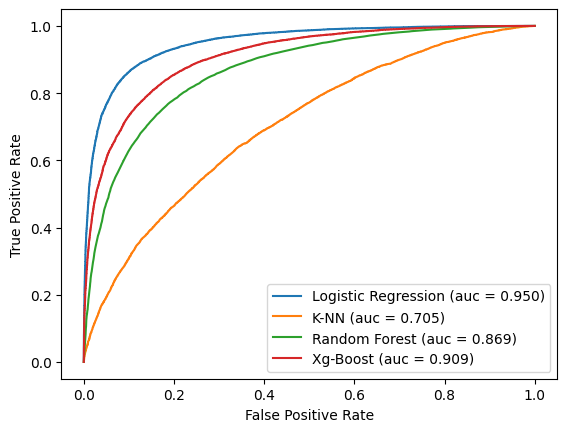

In [27]:
# Roc Curve
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/TFIDF')

models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

plt.figure()
for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_TFIDF_bin)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
# plt.savefig("ROC_curve_TFIDF_all.png")
plt.show()
    

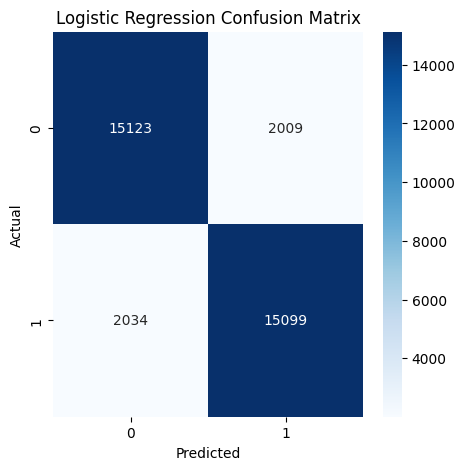

<Figure size 640x480 with 0 Axes>

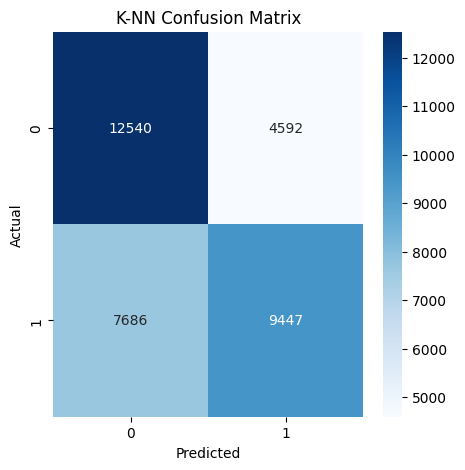

<Figure size 640x480 with 0 Axes>

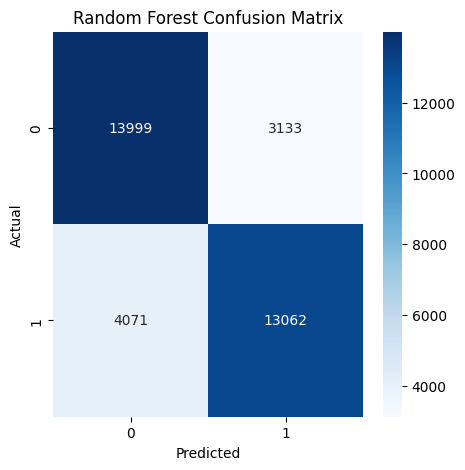

<Figure size 640x480 with 0 Axes>

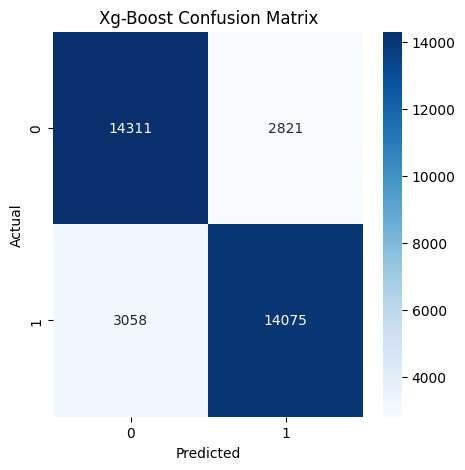

<Figure size 640x480 with 0 Axes>

In [50]:
# Confusion matrices
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/TFIDF')

models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']


for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_TFIDF_bin)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    # plt.savefig(name+"_confusion_matrix.png")
    plt.show()
    plt.clf()

### **3 - Word2Vec**

In [19]:
w2v_model_bin = gensim.models.Word2Vec(X_train_bin, vector_size=300, window=8, min_count=2)

In [20]:
words_bin = set(w2v_model_bin.wv.index_to_key) 

# X_train_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
#                          for ls in X_train_bin])
# X_test_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
#                          for ls in X_test_bin])

In [22]:
# Load final X_train_vect and X_test_vect
path = ''
X_train_bin_vect = np.load(path + "X_train_bin_vect.npy", allow_pickle=True)
X_test_bin_vect = np.load(path + "X_test_bin_vect.npy", allow_pickle=True)

In [23]:
X_train_bin_vect_avg = []
for v in X_train_bin_vect:
    if v.size:
        X_train_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_train_bin_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_bin_vect_avg = []
for v in X_test_bin_vect:
    if v.size:
        X_test_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_test_bin_vect_avg.append(np.zeros(300, dtype=float))

#### Algorithm Implementation

##### Logistic regression

In [26]:
# model = LogisticRegression(random_state=1)

# # Fine tuning
# solvers = ['lbfgs', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10]

# # Define the grid reasearch
# grid = dict(penalty=penalty,C=c_values, solver = solvers)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/lrr_gridsearch_W2V_bin.joblib'
# joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 2/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 1/2] END ..C=500, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 2/2] END ..C=500, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 1/2] END .C=200, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 2/2] END .C=200, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 1/2] END .C=500, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 2/2] END .C=500, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 1/2] END ......C=50, penalty=l2, solver=sag;, score=0.854 total time=   9.1s
[CV 2/2] END ......C=50, penalty=l2, solver=sag;, score=0.857 total time=  10.5s
[CV 1/2] END ....C=500, penalty=l2, solver=saga;, score=0.853 total time=  11.5s
[CV 2/2] END ....C=500, penalty=l2, solver=saga;,

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/lrr_gridsearch_W2V_bin.joblib']

In [30]:
# Load fitted model

path = ''
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_lr_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.855399 using {'solver': 'sag', 'penalty': 'l2', 'C': 50}


##### Random Forest

In [28]:
# model = RandomForestClassifier()

# # FIne tuning
# n_estimators = [10, 50, 70, 100, 200, 300, 400, 500]
# max_features = ['sqrt', 'log2']

# # Define the grid reasearch 
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# # # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin) 
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning
# joblib.dump(grid_result, 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/rf_gridsearch_W2V_bin.joblib')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=50;, score=0.830 total time=  44.0s
[CV 2/2] END max_features=sqrt, n_estimators=50;, score=0.833 total time=  44.0s
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=0.837 total time= 1.5min
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=0.838 total time= 1.5min
[CV 1/2] END max_features=log2, n_estimators=500;, score=0.840 total time= 3.4min
[CV 2/2] END max_features=log2, n_estimators=500;, score=0.842 total time= 4.9min
[CV 1/2] END max_features=sqrt, n_estimators=10;, score=0.798 total time=  12.8s
[CV 2/2] END max_features=sqrt, n_estimators=10;, score=0.801 total time=   8.7s
[CV 1/2] END max_features=sqrt, n_estimators=500;, score=0.841 total time=10.3min
[CV 2/2] END max_features=sqrt, n_estimators=500;, score=0.841 total time= 8.9min
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=0.839 total time= 3.5min
[CV 2/2] END max_features=sqrt, n_estimato

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/rf_gridsearch_W2V_bin.joblib']

In [31]:

# # Load fitted models
path = ''
loaded_grid_search = joblib.load(path)

# # Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# # Save the model with the best performance
model_rf_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.840853 using {'n_estimators': 500, 'max_features': 'log2'}


##### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')
# # Fine funing
# n_neighbors = range(1, 21, 1)

# # Define the grid reasearch
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin)
# end = time()

# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Save the results of the tuning 
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/knn_gridsearch_W2V_bin.joblib'
# joblib.dump(grid_result, path)

In [32]:
# Load fitted model

path = ''
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.817263 using {'n_neighbors': 19}


##### XGBoost

In [33]:
# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train_bin)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='binary:logistic')
# model_xgboost_W2V_bin = model.fit(X_train_bin_vect_avg, y_train_xg)

# # Save holdout
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/xgboost_holdout_W2V_bin.joblib'
# joblib.dump(model_xgboost_W2V_bin, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/xgboost_holdout_W2V_bin.joblib']

In [33]:
# Load fitted model
path = ''
model_xgboost_W2V_bin = joblib.load(path)

### Analysis of the results

In [37]:
models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]

# Make a predict on the test set
results = []
for model in models:
    if model == models[3]:
        y_test_bin_xg = le.fit_transform(y_test_bin)
        print(y_test_bin_xg)
        y_pred = model.predict(X_test_bin_vect_avg)
        acc = accuracy_score(y_test_bin_xg, y_pred)
        prec = precision_score(y_test_bin_xg, y_pred, average='macro')
        recall = recall_score(y_test_bin_xg, y_pred, average='macro')
        f1 = f1_score(y_test_bin_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_bin_vect_avg)
        acc = accuracy_score(y_test_bin, y_pred)
        prec = precision_score(y_test_bin, y_pred, average='macro')
        recall = recall_score(y_test_bin, y_pred, average='macro')
        f1 = f1_score(y_test_bin, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Datafram with results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest model', 'XGBOOST model']
print(df_results)

[1 1 0 ... 0 1 0]
                     Accuracy  Precision    Recall  F1 Score
LR model             0.858952   0.859023  0.858952  0.858945
KNN model            0.824369   0.824379  0.824369  0.824368
Random Forest model  0.846374   0.846403  0.846374  0.846371
XGBOOST model        0.856793   0.856815  0.856793  0.856790


In [38]:
# # Save dataframe
# df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V_bin.csv')

In [102]:
# # Load the results dataframe
# df_results_W2V_bin = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V_bin.csv')
# print(df_results_W2V_bin)

            Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0             LR model  0.858952   0.859023  0.858952  0.858945
1            KNN model  0.824369   0.824379  0.824369  0.824368
2  Random Forest model  0.846374   0.846403  0.846374  0.846371
3        XGBOOST model  0.856793   0.856815  0.856793  0.856790


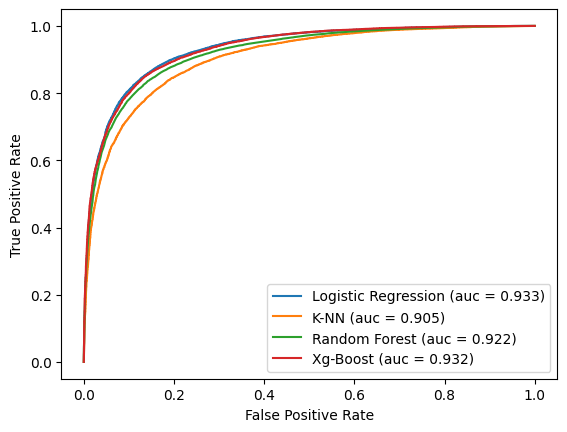

In [34]:
# Roc curves
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/W2V')

models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

plt.figure()
for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_bin_vect_avg)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # plt.savefig("ROC_curve_W2V_all.png")
plt.show()
    

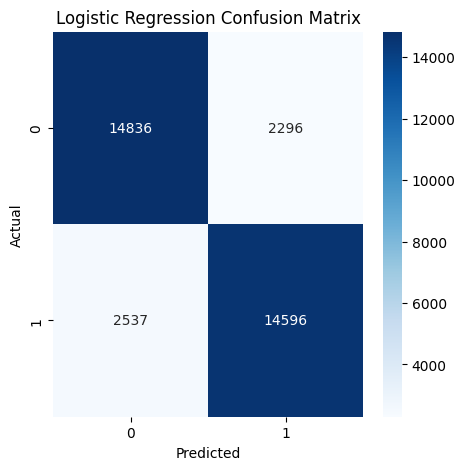

<Figure size 640x480 with 0 Axes>

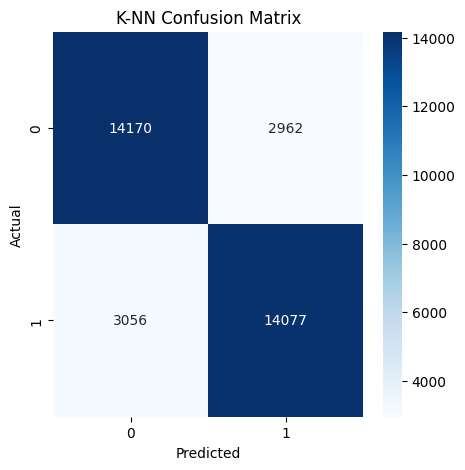

<Figure size 640x480 with 0 Axes>

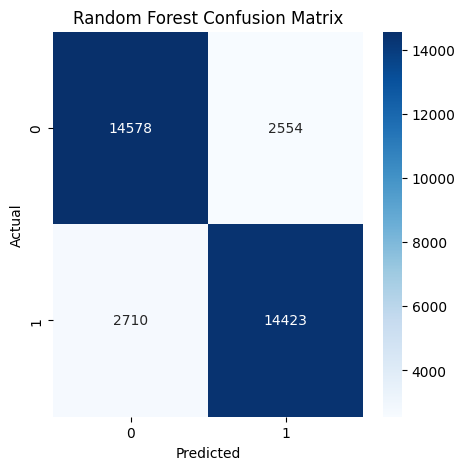

<Figure size 640x480 with 0 Axes>

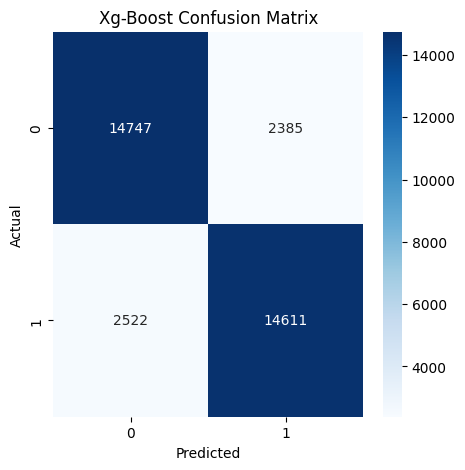

<Figure size 640x480 with 0 Axes>

In [114]:
# Confusion matrices
# os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/W2V')

models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_bin_vect_avg)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    # plt.savefig(name+"_confusion_matrix.png")
    plt.show()
    plt.clf()